In [1]:
import deepchem as dc
import os

import numpy as np
# import tensorflow as tf

import matplotlib.pyplot as plt
import joblib

from rdkit import Chem

from deepchem.molnet import load_pdbbind

from deepchem.models import AtomicConvModel
from deepchem.feat import AtomicConvFeaturizer


2023-12-31 03:11:13.711804: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-31 03:11:13.741081: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-31 03:11:13.741896: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-31 03:11:14.260385: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/gonda/anaconda3/envs/308/l

In [2]:

f1_num_atoms = 100  # maximum number of atoms to consider in the ligand
f2_num_atoms = 1000  # maximum number of atoms to consider in the protein
max_num_neighbors = 12  # maximum number of spatial neighbors for an atom

acf = AtomicConvFeaturizer(frag1_num_atoms=f1_num_atoms,
                      frag2_num_atoms=f2_num_atoms,
                      complex_num_atoms=f1_num_atoms+f2_num_atoms,
                      max_num_neighbors=max_num_neighbors,
                      neighbor_cutoff=4)
tasks, datasets, transformers = load_pdbbind(featurizer=acf,
                                             save_dir='.',
                                             data_dir='.',
                                             pocket=True,
                                             reload=False,
                                             set_name='core')


/home/gonda/anaconda3/envs/308/lib/python3.8/site-packages/deepchem/feat/base_classes.py:213: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(features)


# Transform Data

In [3]:
class MyTransformer(dc.trans.Transformer):
  def transform_array(x, y, w, ids):
    kept_rows = x != None
    X_reshaped = np.squeeze(x[kept_rows], axis=0)  # Remove the first dimension
    Y_reshaped = np.squeeze(y[kept_rows], axis=0)  # Remove the first dimension
    W_reshaped = np.squeeze(w[kept_rows], axis=0)  # Remove the first dimension
    ID_reshaped = np.squeeze(ids[kept_rows], axis=0)  # Remove the first dimension
    return X_reshaped, Y_reshaped, W_reshaped, ID_reshaped


In [4]:
datasets = [d.transform(MyTransformer) for d in datasets]
len(datasets)

/tmp/ipykernel_6245/2209377302.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  kept_rows = x != None
/tmp/ipykernel_6245/2209377302.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  kept_rows = x != None
/tmp/ipykernel_6245/2209377302.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  kept_rows = x != None


3

# Split datasets into train, validation, test

In [5]:
train, val, test = datasets

# ACNN

In [6]:
acm = AtomicConvModel(n_tasks=1,
                      frag1_num_atoms=f1_num_atoms,
                      frag2_num_atoms=f2_num_atoms,
                      complex_num_atoms=f1_num_atoms+f2_num_atoms,
                      max_num_neighbors=max_num_neighbors,
                      batch_size=4,
                      layer_sizes=[32, 32, 16],
                      learning_rate=0.003,
                      )
losses, val_losses = [], []
#max_epochs = 50
max_epochs = 1

metric = dc.metrics.Metric(dc.metrics.score_function.rms_score)
step_cutoff = len(train)//12

def val_cb(model, step):
  if step%step_cutoff!=0:
      return
  val_losses.append(model.evaluate(val, metrics=[metric])['rms_score']**2)  # L2 Loss
  losses.append(model.evaluate(train, metrics=[metric])['rms_score']**2)  # L2 Loss

print("BEGIN TRAIN")
acm.fit(train, nb_epoch=max_epochs, max_checkpoints_to_keep=1,
                callbacks=[val_cb])
print("DONE")


BEGIN TRAIN
DONE


# Visualize loss function 

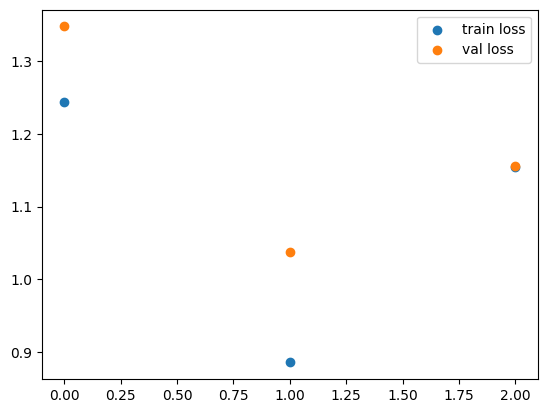

In [7]:
f, ax = plt.subplots()
ax.scatter(range(len(losses)), losses, label='train loss')
ax.scatter(range(len(val_losses)), val_losses, label='val loss')
plt.legend(loc='upper right');

# Predict

In [8]:
npa = acm.predict(test)
print(npa)

[[[-0.32044953]]

 [[ 0.452116  ]]

 [[ 0.30610573]]

 [[ 0.47714704]]

 [[-0.75211746]]

 [[ 0.48390386]]

 [[ 0.4732465 ]]

 [[-1.3310952 ]]

 [[-1.7201221 ]]

 [[ 0.49994108]]

 [[ 0.07807195]]

 [[ 0.02046591]]

 [[ 0.06073958]]

 [[ 0.3761527 ]]

 [[ 0.4957866 ]]

 [[ 0.13985938]]

 [[-0.7110254 ]]

 [[-0.41258806]]

 [[ 0.46818817]]

 [[ 0.5050608 ]]]


In [9]:
data = np.array(npa)

# Mapping Data with PDB 

In [10]:
mapping_dict = {}

for value, array in zip(test.ids, data):
    mapping_dict[value] = array

In [11]:
mapping_dict 

{'4de2': array([[-0.32044953]], dtype=float32),
 '2w66': array([[0.452116]], dtype=float32),
 '3ov1': array([[0.30610573]], dtype=float32),
 '3pe2': array([[0.47714704]], dtype=float32),
 '2ole': array([[-0.75211746]], dtype=float32),
 '2d1o': array([[0.48390386]], dtype=float32),
 '3cyx': array([[0.4732465]], dtype=float32),
 '1a30': array([[-1.3310952]], dtype=float32),
 '3f3e': array([[-1.7201221]], dtype=float32),
 '1os0': array([[0.49994108]], dtype=float32),
 '3g2n': array([[0.07807195]], dtype=float32),
 '1sln': array([[0.02046591]], dtype=float32),
 '2gss': array([[0.06073958]], dtype=float32),
 '3fk1': array([[0.3761527]], dtype=float32),
 '1igj': array([[0.4957866]], dtype=float32),
 '3udh': array([[0.13985938]], dtype=float32),
 '3pxf': array([[-0.7110254]], dtype=float32),
 '3ao4': array([[-0.41258806]], dtype=float32),
 '3uo4': array([[0.46818817]], dtype=float32),
 '1f8b': array([[0.5050608]], dtype=float32)}